In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/release')

warnings.filterwarnings('ignore')

In [2]:
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

from utils.dataset import *
from utils.decomposition.decomposition_utils import *

transform = Reshape2DField()
vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_time=True)
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
runt_dataset = AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform)
eve_dataset = AtlasDataset('WT', 'Even_Skipped', 'velocity2D', transform=transform, drop_time=True)
hist_dataset = AtlasDataset('WT', 'histone-RFP', 'velocity2D', transform=transform, drop_time=True)

100%|██████████| 5/5 [00:00<00:00, 12.86it/s]


## Tissue flow is stereotypic

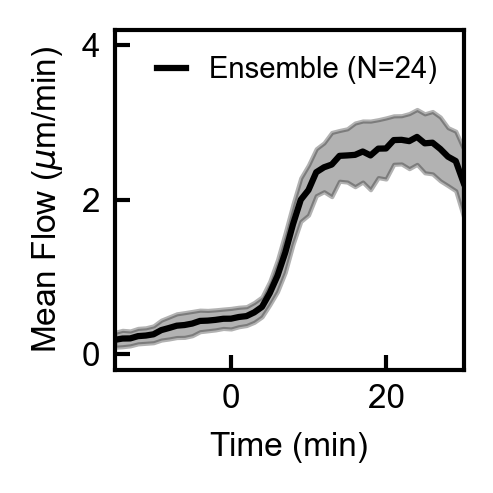

In [3]:
from scipy.stats import sem

plt.style.use('Figure1/Figure1.mplstyle')


fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

df = pd.DataFrame()
N = 0
for dataset in [sqh_dataset, cad_dataset, runt_dataset, eve_dataset, hist_dataset]:
    for eId in dataset.df.embryoID.unique():
        values = dataset.values[eId]
        time = dataset.df.loc[dataset.df.embryoID == eId, 'time']
        eIdx = dataset.df.loc[dataset.df.embryoID == eId, 'eIdx']
        norm = np.linalg.norm(values.reshape([values.shape[0], -1, *values.shape[-2:]]), axis=1).mean(axis=(1, 2))
        if 'Runt' in dataset.label or 'Eve' in dataset.label:
            norm /= 0.2619 / 0.4
        if 'hist' in dataset.label:
            norm *= 0.2619 / 0.4
        df = df.append(pd.DataFrame({
            'time': time.values,
            'v': norm[eIdx.values]
        }), ignore_index=True)
        N += 1

df['time'] = np.round(df.time.values)
df = df.groupby('time')['v'].agg(['mean', sem]).reset_index()

ax.plot(df['time'], df['mean'], 
        color='black', 
        label='Ensemble (N=%d)' % N)
ax.fill_between(
    df['time'],
    df['mean'] - 3*df['sem'],
    df['mean'] + 3*df['sem'],
    color='black', alpha=0.3
)

ax.set_xlim([-15, 30])
ax.set_yticks([0, 2, 4])
ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax.set_ylim([-0.2, 4.2])
ax.set_xlabel('Time (min)')
ax.legend(loc='upper right', framealpha=0)

plt.savefig('Figure1/FlowTimeline.pdf')


## Components of flow

Found SVDPipeline for this dataset!
(2, 2, 236, 200)


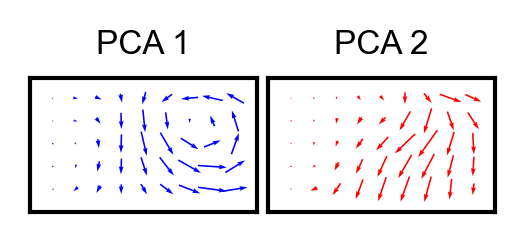

In [6]:
from utils.plot_utils import plot_vector2D

plt.style.use('Figure1/Figure1.mplstyle')
model, df = get_decomposition_results(vel_dataset, overwrite=False)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = [-15, 0, 20]

kwargs = dict(skip=20, width=0.007)

z = model['masker'].inverse_transform(model['svd'].components_)
z = z * np.sqrt(model['svd'].explained_variance_[:, None, None, None])

z = np.load('PrimaryPCsFlow.npy')

fig, ax = plt.subplots(1, 2, figsize=(2, 1))

plot_vector2D(ax[0], z[0], color='blue', **kwargs)
plot_vector2D(ax[1], z[1], color='red', **kwargs)

ax[0].set_title('PCA 1')
ax[1].set_title('PCA 2')
fig.subplots_adjust(wspace=0.05, hspace=0.05)

#fig.savefig('Figure1/velocity_components')
print(z.shape)
#np.save('PrimaryPCsFlow', z[:2])

Found SVDPipeline for this dataset!


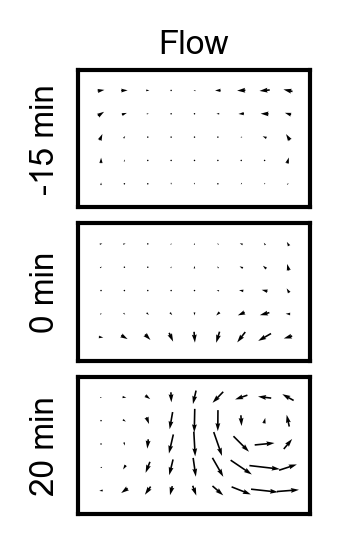

In [10]:
from utils.plot_utils import plot_vector2D
plt.style.use('Figure1/Figure1.mplstyle')

model, df = get_decomposition_results(vel_dataset, overwrite=False)

df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = [-15, 0, 20]

kwargs = dict(skip=20, width=0.007)

fig, ax = plt.subplots(3, 1, figsize=(1, 2.))

for i in range(len(t)):
    row = (data.t - t[i]).abs().argmin()
    row = data.iloc[row].filter(like='param').values
    z = model.inverse_transform(row[None])[0]
    plot_vector2D(ax[i], z, **kwargs, scale=50 if i == 2 else 20)


ax[0].set_xlabel('Flow')
    
for i in range(3):
    ax[i].set_ylabel('%d min' % t[i])
    ax[i].xaxis.set_label_position('top')
                            
fig.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig('Figure1/velocity_time')

Found SVDPipeline for this dataset!


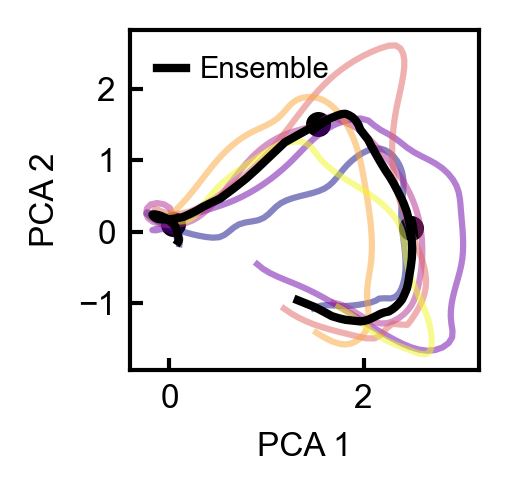

In [75]:
from scipy.interpolate import splprep, splev

plt.style.use('Figure1/Figure1.mplstyle')

model, df = get_decomposition_results(vel_dataset, overwrite=False)
tmin, tmax = -15, 45
df = df[(df.t >= tmin) & (df.t <= tmax)]

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

colors = plt.cm.plasma(np.linspace(0, 1, len(df.embryoID.unique())))
for i, embryoID in enumerate(df.embryoID.unique()):
    data = df[df.embryoID == embryoID].sort_values('t')
    data = data.loc[:, ['param0', 'param1']]
    data = data.drop_duplicates()
    x = data.param0.values
    y = data.param1.values
    
    #Smooth using spline interpolant in between timepoints
    f, _ = splprep([x, y], s=.01)
    x, y, = splev(np.linspace(0, 1, 100), f)
    
    ax.plot(x, y, c=colors[i], alpha=0.5)

from scipy.interpolate import interp1d

#Plot ensemble
df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
p0 = interp1d(data.t, data.param0, fill_value='extrapolate')
p1 = interp1d(data.t, data.param1, fill_value='extrapolate')
ax.plot(p0(t), p1(t),
        color='black', lw=2, label='Ensemble')

#Add timepoints
t = [-10, 10, 25]
ax.scatter(p0(t), p1(t), s=25, color='black')

ax.set(xlabel='PCA 1',
       ylabel='PCA 2')
ax.legend(loc='upper left')

fig.savefig('Figure1/velocity_trajectory')

## What does PCA look like

Found SVDPipeline for this dataset!
[2.35516629 0.66792531 0.40401635]


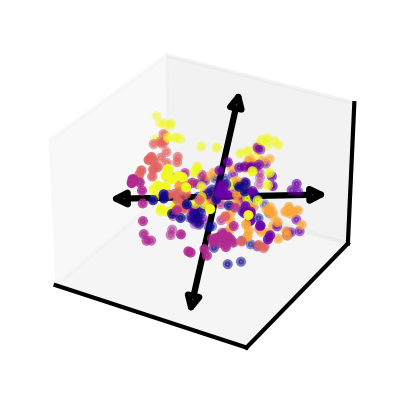

In [176]:
from scipy.interpolate import interp1d
from sklearn.random_projection import GaussianRandomProjection

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

plt.style.use('Figure1/Figure1.mplstyle')

model, df = get_decomposition_results(vel_dataset, overwrite=False)
tmin, tmax = -15, 45
df = df[(df.t >= tmin) & (df.t <= tmax)]
df['id'] = df.groupby('embryoID').ngroup()

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), 
                       subplot_kw=dict(facecolor='none', 
                                       projection='3d',
                                       proj_type='persp'))
X = df.filter(like='param').values
#random = GaussianRandomProjection(3)
#y = random.fit_transform(X)
ax.scatter(y[:, 0], y[:, 1], y[:, 2], c=df.id, cmap='plasma', s=2)

#Add timepoints
t = [-10, 10, 25]

cpts = np.eye(3, model.n_components)
cpts = random.transform(cpts)
cpts /= np.linalg.norm(cpts, axis=1, keepdims=True)
cpts *= 0.7 * np.mean([np.ptp(ax.get_xlim()), np.ptp(ax.get_ylim()), np.ptp(ax.get_zlim())])


origin = np.mean(y, axis=0)
print(origin)
for i in range(2):
    a = Arrow3D([origin[0] - cpts[i, 0], origin[0] + cpts[i, 0]],
                [origin[1] - cpts[i, 1], origin[1] + cpts[i, 1]],
                [origin[2] - cpts[i, 2], origin[2] + cpts[i, 2]],
                lw=1.5, arrowstyle='<|-|>',
                mutation_scale=7)
    ax.add_artist(a)
ax.grid(False)
ax.set(xticks=[], yticks=[], zticks=[])

plt.draw()
#ax.axis('off')

#Plot ensemble
df['t'] = np.round(df['t'])
data = df.groupby('t').agg(np.mean).reset_index()
t = np.linspace(tmin, tmax, 100)
X = data.filter(like='param').values
X = interp1d(data.t, X, fill_value='extrapolate', axis=0)

t = np.array([-10, 0, 10])
X = random.transform(X(t))

plt.savefig('Figure2/PCA_demo.png', dpi=350)

#import pickle as pk
#pk.dump(random, open('Figure2/RandomProjection.pkl', 'wb'))

## ML Forecasting

In [16]:
from atlas_processing.anisotropy_detection import cell_size
from torchvision.transforms import Compose

from utils.dataset import *
from utils.decomposition.decomposition_utils import *

transform = Reshape2DField()

sqh = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_time=True)
cad = AtlasDataset('WT', 'ECad-GFP', 'raw2D', 
                           transform=Compose([transform, 
                                              Smooth2D(sigma=7)]))
runt = AtlasDataset('WT', 'Runt', 'raw2D',
                            transform=Compose([transform, 
                                              Smooth2D(sigma=3)]))

100%|██████████| 6/6 [00:00<00:00,  9.98it/s]


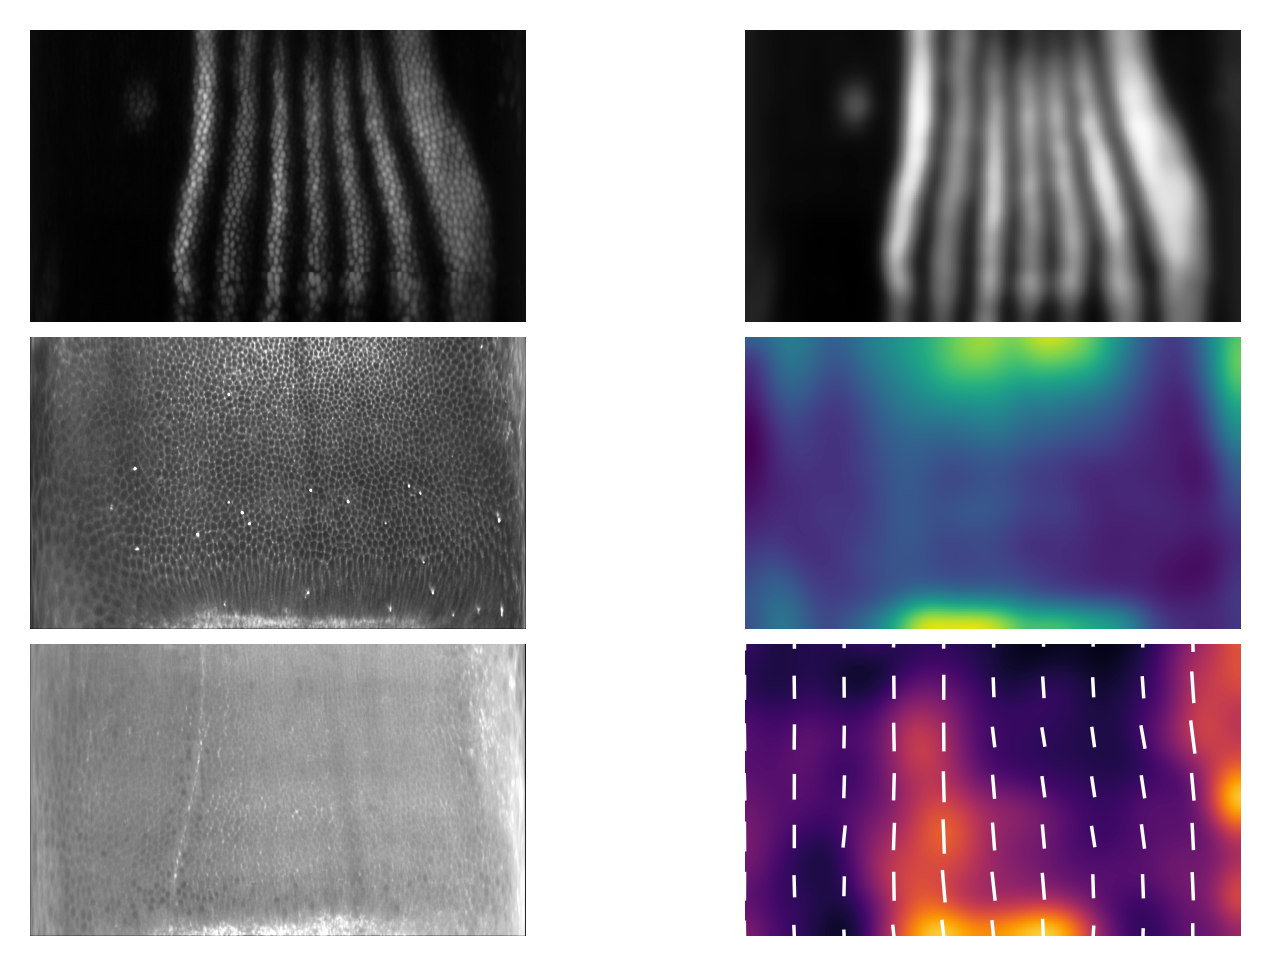

In [78]:
plt.style.use('Figure1/Figure1.mplstyle')
plt.rcParams['axes.linewidth'] = 0.

from PIL import Image
from utils.plot_utils import color_2D, plot_tensor2D

time = 0

cmap = ['Greys_r', 'viridis', 'inferno']

fig, ax = plt.subplots(3, 2, dpi=300)
for i, dataset in enumerate([runt, cad, sqh]):
    rows = dataset.df[np.abs(dataset.df.time - time) < 1]
    row = rows.iloc[2]
    proc = dataset[row.name]['value']
    tiff = os.path.join(row.folder, row.tiff)
    
    tiff = Image.open(tiff)
    tiff.seek(row.eIdx)
    
    color_2D(ax[i, 0], np.array(tiff)[None], cmap='Greys_r', vmin=np.min(tiff), vmax=np.min(tiff)+10*np.std(tiff))
    
    if proc.shape[0] == 4:
        plot_tensor2D(ax[i, 1], proc, cmap=cmap[i])
    else:
        color_2D(ax[i, 1], proc, cmap=cmap[i])
        
fig.subplots_adjust(wspace=0.05, hspace=0.05)
    
plt.savefig('Figure1/ML_Inputs')


100%|██████████| 6/6 [00:00<00:00,  9.77it/s]


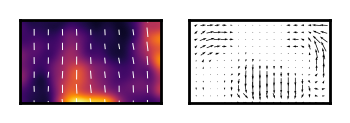

In [17]:
from utils.dataset import *
from utils.plot_utils import *
from utils.vae.training import train_val_split
from torchvision.transforms import Compose

transform = Compose([
    Reshape2DField(),
    ToTensor()
])

sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', 
                           transform=transform, drop_time=True)
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', 
                               transform=transform, drop_time=True)

dataset = TrajectoryDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
], 
ensemble=2)

batch = dataset[130]

fig, ax = plt.subplots(1, 2, dpi=200, figsize=(2, 1))
plot_tensor2D(ax[0], batch['m_ij'][0].numpy(), alpha=batch['train_mask'].float(), cmap='inferno')
plot_vector2D(ax[1], batch['v'][0])

In [18]:
from utils.vae.convnext_models import *

beta=0
#info = torch.load('../../tb_logs/March2023/MaskedVAE_Evolver_sqh_beta=0_split=embryo')
info = torch.load('../../tb_logs/November2023/MaskedVAE_Evolver_sqh_beta=0_split=embryo')
print('Loss = ', info['loss'])
model = MaskedVAE_Evolver(**info['hparams'])
model.load_state_dict(info['state_dict'], strict=False);

Loss =  0.05839801260403223


In [19]:
dataset.ensemble = 6

def ensemble_key(dataset, key, time):
    df = dataset.df[dataset.df.key == key]
    nearest = df[(df.time - time).abs() < 1]

    frame = []
    for i, row in nearest.iterrows():
        data = dataset.values[row.embryoID][key][row.eIdx]
        if dataset.transforms[row.dataset_idx] is not None:
            data = dataset.transforms[row.dataset_idx](data)
        frame.append(data)

    if torch.is_tensor(frame[0]):
        frame = torch.mean(torch.stack(frame), dim=0)
    elif isinstance(frame[0], np.ndarray):
        frame = np.mean(np.stack(frame), axis=0)

    return frame

def get_ensemble_trajectory(dataset, tmin, tmax):
    times = np.arange(tmin, tmax, dtype=int)
    sample = {}
    for key in dataset.keys:
        sample[key] = []
        for t in times:
            sample[key].append(ensemble_key(dataset, key, t))
    
        sample[key] = torch.stack(sample[key], dim=0)
    sample['time'] = times
    return sample

from math import floor, ceil
from scipy.interpolate import RectBivariateSpline as interp2d

def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def rk4DynamicVelocity2D(pts, X0v, Y0v, v, hh):
    tt = np.arange(0, v.shape[0]-1, hh)
    xyPathsMat = np.zeros([pts.shape[0], len(tt), 2])

    x = pts[:, 0]
    y = pts[:, 1]
    xyPathsMat[:, 0, 0] = x
    xyPathsMat[:, 0, 1] = y
    
    Xmin, Xmax = X0v[0], X0v[-1]
    Ymin, Ymax = Y0v[0], Y0v[-1]
    
    for ii in range(len(tt) - 1):
        k1x, k1y = get_velocity(v, tt[ii], X0v, Y0v, x, y)
        k2x, k2y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k1x, y + 0.5 * hh * k1y)
        k3x, k3y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k2x, y + 0.5 * hh * k2y)
        k4x, k4y = get_velocity(v, tt[ii] + hh, X0v, Y0v, x + hh * k3x, y + hh * k3y)
        
        #Main equation
        x = x + (k1x + 2 * k2x + 2 * k3x + k4x) * hh / 6.
        y = y + (k1y + 2 * k2y + 2 * k3y + k4y) * hh / 6.
        
        x[x > Xmax] = Xmax
        x[x < Xmin] = Xmin
        y[y > Ymax] = Ymax
        y[y < Ymin] = Ymin
        
        xyPathsMat[:, ii, 0] = x
        xyPathsMat[:, ii, 1] = y
            
    return xyPathsMat

nDV, nAP = 10, 10
DV = np.linspace(dv_min, dv_max, nDV)
AP = np.linspace(ap_min, ap_max, nAP)

hh = 0.2
DV += 0.5 * (dv_max - DV[-1])
AP += 0.5 * (ap_max - AP[-1])
pts = np.stack(np.meshgrid(AP, DV, indexing='xy'), axis=-1).reshape([-1, 2])

DV = np.linspace(dv_min, dv_max, 236)
AP = np.linspace(ap_min, ap_max, 200)

batch = get_ensemble_trajectory(dataset, 5, 25)
device = torch.device('cuda:0')
model.eval()
model.to(device)
with torch.no_grad():
    #x = torch.cat([batch['m_ij'], batch['c']], dim=1)
    x = batch['m_ij']
    y0 = batch['v']
    y, pl = model(x[0:1].to(device), torch.tensor([x.shape[0]]).to(device))
    y = y[0].cpu().numpy()
    y0 = y0.cpu().numpy()
    x = x.cpu().numpy()
    print(x.shape, y0.shape, y.shape)
    
    y0Paths = rk4DynamicVelocity2D(pts, AP, DV, y0, hh)
    yPaths  = rk4DynamicVelocity2D(pts, AP, DV, y,  hh)
    print(y0Paths.shape, yPaths.shape)

(20, 4, 236, 200) (20, 2, 236, 200) (20, 2, 236, 200)
(100, 95, 2) (100, 95, 2)


(20, 2, 236, 200) (20, 2, 236, 200)


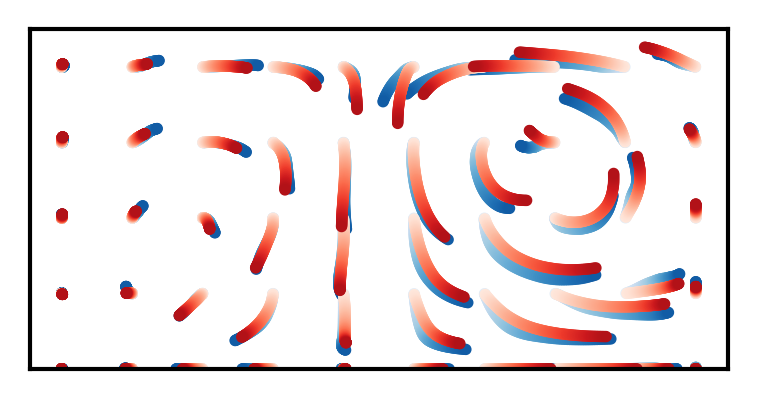

In [21]:
#Demonstrate ensemble of cell trajectories
plt.style.use('Figure1/Figure1.mplstyle')

fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))

labels = ['Experiment', 'ML']
cmaps = [
    'Blues',
    'Reds',
]
print(y0.shape, y.shape)
#for i, v, in enumerate([y0, y]):
for i, paths in enumerate([y0Paths, yPaths]):
    nPts = paths.shape[0]
    nTps = paths.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(paths[:, tpId, 0], paths[:, tpId, 1], s=3, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
        
ax.set(xticks=[], yticks=[])
ax.set_ylim([dv_min, dv_midpoint])
ax.set_aspect('auto')

plt.savefig('Figure1/RNN_Forecasting.png')

(20, 2, 236, 200) (20, 2, 236, 200)


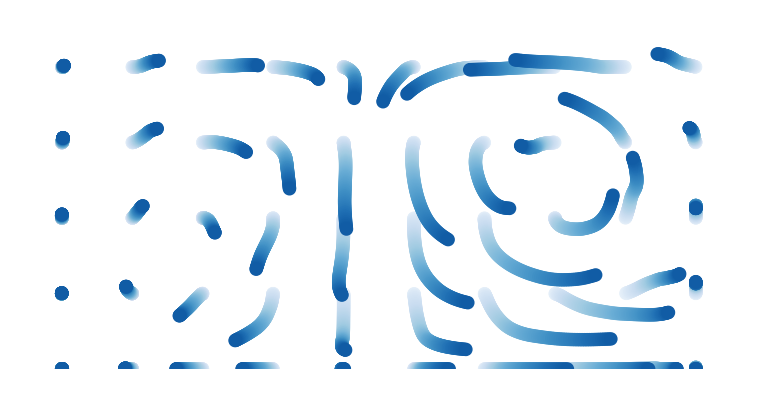

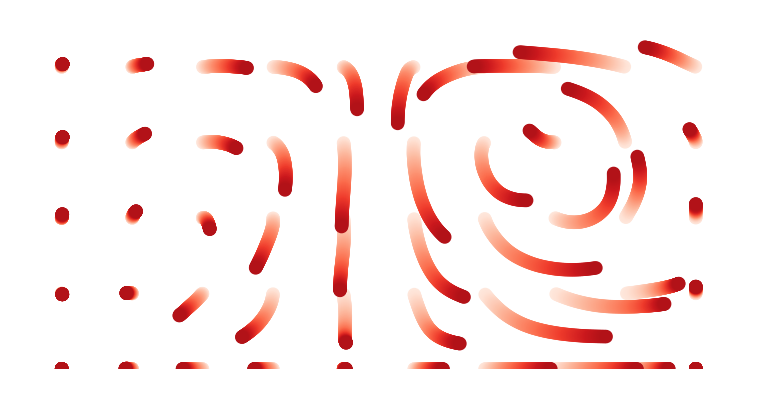

In [22]:
#Demonstrate ensemble of cell trajectories
plt.style.use('Figure1/Figure1.mplstyle')

fig1, ax1 = plt.subplots(1, 1, figsize=(3, 1.5))
fig2, ax2 = plt.subplots(1, 1, figsize=(3, 1.5))
labels = ['Experiment', 'ML']
cmaps = [
    'Blues',
    'Reds',
]
print(y0.shape, y.shape)
i = 0
for ax, paths, in zip([ax1, ax2], [y0Paths, yPaths]):
    nPts = paths.shape[0]
    nTps = paths.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(paths[:, tpId, 0], paths[:, tpId, 1], s=5, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
    i += 1

    ax.set(xticks=[], yticks=[])
    ax.set_ylim([dv_min, dv_midpoint])
    ax.set_aspect('auto')
    ax.axis('off')

fig1.savefig('Figure1/EXP_trajectories.png', dpi=350)
fig2.savefig('Figure1/RNN_trajectories.png', dpi=350)

# Evaluation of different inputs

MaskedVAE_Evolver_rnt,prd_beta=0_split=embryo
MaskedVAE_Evolver_sqh_beta=0_split=embryo
MaskedVAE_Evolver_rnt,eve_beta=0_split=embryo
MaskedVAE_Evolver_rnt_beta=0_split=embryo
MaskedVAE_Evolver_rnt,ftz_beta=0_split=embryo
MaskedVAE_Evolver_cad_beta=0_split=embryo
MaskedVAE_Evolver_cad,rnt_beta=0_split=embryo
MaskedVAE_Evolver_eve_beta=0_split=embryo
MaskedVAE_Evolver_rnt,slp_beta=0_split=embryo
MaskedVAE_Evolver_eve,trt_beta=0_split=embryo
MaskedVAE_Evolver_sqh,eve_beta=0_split=embryo
MaskedVAE_Evolver_sqh,rnt_beta=0_split=embryo
MaskedVAE_Evolver_rnt,trt_beta=0_split=embryo
MaskedVAE_Evolver_sqh,cad_beta=0_split=embryo
MaskedVAE_Evolver_rnt,eve,ftz_beta=0_split=embryo
MaskedVAE_Evolver_eve,slp_beta=0_split=embryo
MaskedVAE_Evolver_eve,ftz_beta=0_split=embryo
MaskedVAE_Evolver_rnt,eve,prd_beta=0_split=embryo
MaskedVAE_Evolver_cad,eve_beta=0_split=embryo
MaskedVAE_Evolver_rnt,eve,slp_beta=0_split=embryo
MaskedVAE_Evolver_eve,prd_beta=0_split=embryo
MaskedVAE_Evolver_rnt,eve,trt_beta=0_s

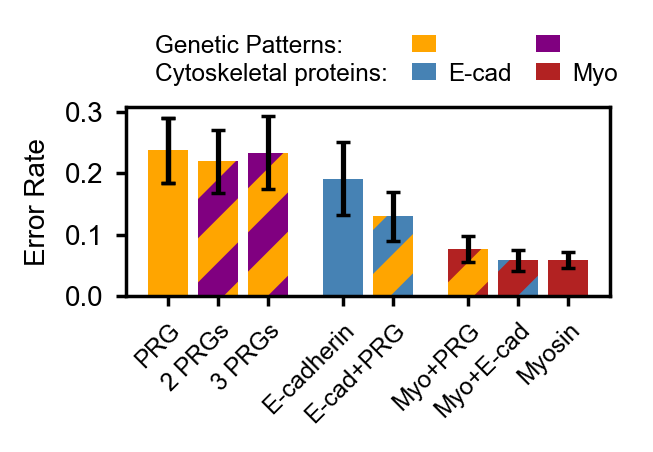

In [3]:
plt.style.use('Figure1/Figure1.mplstyle')

plt.rcParams['figure.frameon'] = True
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .2
plt.rcParams['legend.columnspacing'] = 1.
plt.rcParams['errorbar.capsize'] = 2

import matplotlib
import torch

logdir = '../../tb_logs/November2023'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'MaskedVAE_Evolver*embryo*')):
    info = torch.load(d, map_location='cpu')
    try:
        data = data.append({
            'inputs': '+'.join(info['hparams']['input']).title(),
            'loss': info['res'],
            'yerr': info['res_std'],
            'epoch': info['epoch'],
        }, ignore_index=True)
        print(os.path.basename(d))
    except Exception as e:
        print(f'\tSkipping {os.path.basename(d)}')
        print(e)
        #The E-cadherin only (and cad,sqh) models before SIGMA=7
        #used incorrect assumptions so they get skipped
        continue
data = data.sort_values('loss')
data = data.set_index('inputs')
print(data)

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'PRG1': 'orange',
    'PRG2': 'purple',
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2.5, 1))
labels = []
offset = 0

#Pair Rule Genes
idxs = ['Rnt', 'Eve']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG2'], label='a')
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG1'], label='PRG')
labels.append('PRG')

idxs=['Rnt+Eve', 'Rnt+Ftz', 'Rnt+Trt', 'Rnt+Slp', 'Rnt+Prd','Eve+Ftz', 'Eve+Trt', 'Eve+Slp', 'Eve+Prd']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG1'], 
       edgecolor=colors['PRG2'], hatch='/', lw=0)
labels.append('2 PRGs')

di=data.loc[[c for c in data.index if 'Rnt+Eve+' in c]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG1'],
       edgecolor=colors['PRG2'],
       hatch='/', lw=0)
labels.append('3 PRGs')

offset += 0.5

ax.bar(len(labels)+offset, data.loss['Cad'], yerr=data.yerr['Cad'], facecolor=colors['Cad'], label='E-cad')
labels.append('E-cadherin')

di=data.loc[['Cad+Rnt', 'Cad+Eve']]
ax.bar(len(labels)+offset, di.loss.mean(), yerr=di.yerr.mean(),
       facecolor=colors['Cad'], edgecolor=colors['PRG1'],
       hatch='/', lw=0)
labels.append('E-cad+PRG')

offset += 0.5

di=data.loc[['Sqh+Rnt', 'Sqh+Eve']]
ax.bar(len(labels)+offset, di.loss.mean(), yerr=di.yerr.mean(),
       facecolor=colors['Sqh'], edgecolor=colors['PRG1'],
       hatch='/', lw=0)
labels.append('Myo+PRG')

di=data.loc[['Sqh+Cad']]
ax.bar(len(labels)+offset, di.loss, yerr=di.yerr, 
       facecolor=colors['Sqh'], edgecolor=colors['Cad'],
       hatch='/', lw=0)
labels.append('Myo+E-cad')

ax.bar(len(labels)+offset, data.loss['Sqh'], yerr=data.yerr['Sqh'], facecolor=colors['Sqh'], label='Myo')
labels.append('Myosin')

bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)][1:]
xticks = [bar.xy[0] + bar.get_width() / 2 for bar in bars[:-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(labels, rotation=45, 
                   fontsize=7, rotation_mode='anchor', ha='right');
ax.set_ylabel('Error Rate')
ax.set_yticks([0, 0.1, 0.2, 0.3])

blank = ax.plot([], marker="", ls="")[0]

from copy import copy
h, l = ax.get_legend_handles_labels()
#h.insert(0, copy(h[0]))
#l.insert(0, '')
#h[1].patches[0].set_facecolor(colors['PRG2'])
#l[1] = ''
l[0] = ''
l[1] = ''
h[0], h[1] = h[1], h[0]
l = np.array(l).reshape([2, 2]).T.flatten().tolist()
h = np.array(h).reshape([2, 2]).T.flatten().tolist()

h.insert(0, blank)
l.insert(0, 'Genetic Patterns:')
h.insert(1, blank)
l.insert(1, 'Cytoskeletal proteins:')


ax.legend(h, l, ncol=3,
          bbox_to_anchor=[0.5, 1],
          loc='lower center')

plt.savefig('Figure1/ForecastingErrorBars.png', dpi=350)
plt.savefig('Figure1/ForecastingErrorBars.svg', dpi=350)

VAE_Evolver_rnt,trt_beta=0_split=embryo
VAE_Evolver_eve,slp_beta=0_split=embryo
VAE_Evolver_cad,eve_beta=0_split=embryo
VAE_Evolver_rnt,prd_beta=0_split=embryo
VAE_Evolver_rnt,eve,trt_beta=0_split=embryo
VAE_Evolver_rnt_beta=0_split=embryo
VAE_Evolver_rnt,slp_beta=0_split=embryo
	Skipping VAE_Evolver_cad_beta=0.0001_split=embryo
	Skipping VAE_Evolver_sqh,cad_beta=0_split=embryo
VAE_Evolver_eve,prd_beta=0_split=embryo
VAE_Evolver_eve_beta=0_split=embryo
VAE_Evolver_rnt,ftz_beta=0_split=embryo
VAE_Evolver_sqh,cad_beta=0_split=embryo_SIGMA=7
VAE_Evolver_sqh_beta=0_split=embryo
VAE_Evolver_cad_beta=0_split=embryo_SIGMA=7
VAE_Evolver_rnt,eve,prd_beta=0_split=embryo
VAE_Evolver_eve,trt_beta=0_split=embryo
VAE_Evolver_sqh,eve_beta=0_split=embryo
VAE_Evolver_eve,ftz_beta=0_split=embryo
VAE_Evolver_sqh,rnt_beta=0_split=embryo
VAE_Evolver_cad,rnt_beta=0_split=embryo_SIGMA=7
VAE_Evolver_rnt,eve,ftz_beta=0_split=embryo
VAE_Evolver_rnt,eve_beta=0_split=embryo
VAE_Evolver_cad,rnt_beta=0_split=embryo

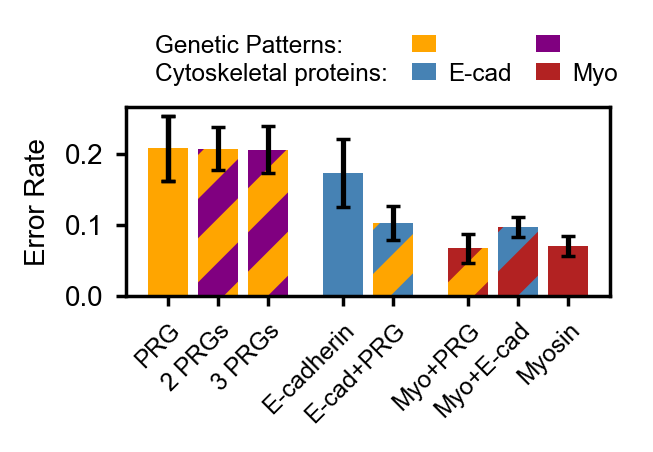

In [15]:
plt.style.use('Figure1/Figure1.mplstyle')

plt.rcParams['figure.frameon'] = True
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .2
plt.rcParams['legend.columnspacing'] = 1.
plt.rcParams['errorbar.capsize'] = 2

import matplotlib
import torch

logdir = '../../tb_logs/March2023'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver*embryo*')):
    info = torch.load(d, map_location='cpu')
    try:
        data = data.append({
            'inputs': '+'.join(info['hparams']['input']).title(),
            'loss': info['loss'],
            'yerr': info['redo_sem'],
            'epoch': info['epoch'],
        }, ignore_index=True)
        print(os.path.basename(d))
    except:
        print(f'\tSkipping {os.path.basename(d)}')
        #The E-cadherin only (and cad,sqh) models before SIGMA=7
        #used incorrect assumptions so they get skipped
        continue
data = data.sort_values('loss')
data = data.set_index('inputs')

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'PRG1': 'orange',
    'PRG2': 'purple',
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2.5, 1))
labels = []
offset = 0

#Pair Rule Genes
idxs = ['Rnt', 'Eve']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG2'], label='a')
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG1'], label='PRG')
labels.append('PRG')

idxs=['Rnt+Eve', 'Rnt+Ftz', 'Rnt+Trt', 'Rnt+Slp', 'Rnt+Prd','Eve+Ftz', 'Eve+Trt', 'Eve+Slp', 'Eve+Prd']
di = data.loc[[c for c in idxs if c in data.index]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG1'], 
       edgecolor=colors['PRG2'], hatch='/', lw=0)
labels.append('2 PRGs')

di=data.loc[[c for c in data.index if 'Rnt+Eve+' in c]]
ax.bar(len(labels)+offset, di.loss.mean(),
       yerr=di.yerr.mean(),
       facecolor=colors['PRG1'],
       edgecolor=colors['PRG2'],
       hatch='/', lw=0)
labels.append('3 PRGs')

offset += 0.5

ax.bar(len(labels)+offset, data.loss['Cad'], yerr=data.yerr['Cad'], facecolor=colors['Cad'], label='E-cad')
labels.append('E-cadherin')

di=data.loc[['Cad+Rnt', 'Cad+Eve']]
ax.bar(len(labels)+offset, di.loss.mean(), yerr=di.yerr.mean(),
       facecolor=colors['Cad'], edgecolor=colors['PRG1'],
       hatch='/', lw=0)
labels.append('E-cad+PRG')

offset += 0.5

di=data.loc[['Sqh+Rnt', 'Sqh+Eve']]
ax.bar(len(labels)+offset, di.loss.mean(), yerr=di.yerr.mean(),
       facecolor=colors['Sqh'], edgecolor=colors['PRG1'],
       hatch='/', lw=0)
labels.append('Myo+PRG')

di=data.loc[['Sqh+Cad']]
ax.bar(len(labels)+offset, di.loss, yerr=di.yerr, 
       facecolor=colors['Sqh'], edgecolor=colors['Cad'],
       hatch='/', lw=0)
labels.append('Myo+E-cad')

ax.bar(len(labels)+offset, data.loss['Sqh'], yerr=data.yerr['Sqh'], facecolor=colors['Sqh'], label='Myo')
labels.append('Myosin')

bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)][1:]
xticks = [bar.xy[0] + bar.get_width() / 2 for bar in bars[:-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(labels, rotation=45, 
                   fontsize=7, rotation_mode='anchor', ha='right');
ax.set_ylabel('Error Rate')

blank = ax.plot([], marker="", ls="")[0]

from copy import copy
h, l = ax.get_legend_handles_labels()
#h.insert(0, copy(h[0]))
#l.insert(0, '')
#h[1].patches[0].set_facecolor(colors['PRG2'])
#l[1] = ''
l[0] = ''
l[1] = ''
h[0], h[1] = h[1], h[0]
l = np.array(l).reshape([2, 2]).T.flatten().tolist()
h = np.array(h).reshape([2, 2]).T.flatten().tolist()

h.insert(0, blank)
l.insert(0, 'Genetic Patterns:')
h.insert(1, blank)
l.insert(1, 'Cytoskeletal proteins:')

ax.legend(h, l, ncol=3,
          bbox_to_anchor=[0.5, 1],
          loc='lower center')

#plt.savefig('Figure1/ForecastingErrorBars.png', dpi=350)

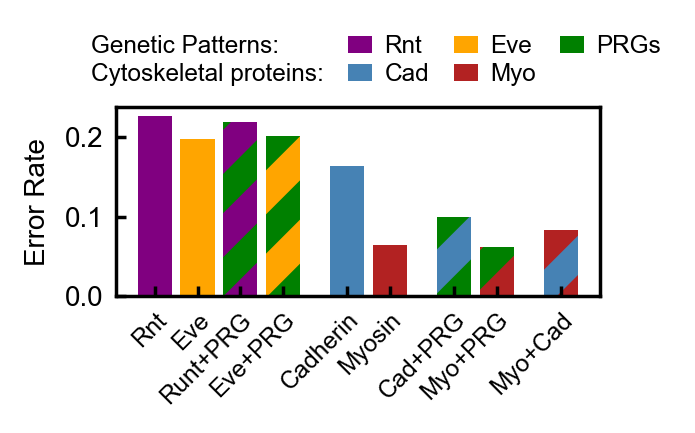

In [178]:
plt.style.use('Figure1/Figure1.mplstyle')

plt.rcParams['figure.frameon'] = True
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .2
plt.rcParams['legend.columnspacing'] = 1.

import matplotlib

logdir = '../../tb_logs/March2023'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver*LR')):
    info = torch.load(d, map_location='cpu')
    data = data.append({
        'inputs': '+'.join(info['hparams']['input']).title(),
        'loss': info['loss']
    }, ignore_index=True)
data = data.sort_values('loss')
data = data.set_index('inputs')

#print(data)

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'Rnt': 'purple',
    'Eve': 'orange',
    'PRG': 'green',
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2.5, 1))
labels = []
offset = 0

#Pair Rule Genes
ax.bar(len(labels)+offset, data.loss['Rnt'], facecolor=colors['Rnt'], label='Rnt')
labels.append('Rnt')

ax.bar(len(labels)+offset, data.loss['Eve'], facecolor=colors['Eve'], label='Eve')
labels.append('Eve')


idxs = [c for c in data.index if 'Rnt+' in c]
ax.bar(len(labels)+offset, data.loss[idxs].mean(),
       facecolor=colors['Rnt'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Runt+PRG')

idxs = [c for c in data.index if 'Eve+' in c]
ax.bar(len(labels)+offset, data.loss[idxs].mean(),
       facecolor=colors['Eve'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Eve+PRG')

offset += 0.5

ax.bar(len(labels)+offset, data.loss['Cad'], facecolor=colors['Cad'], label='Cad')
labels.append('Cadherin')
ax.bar(len(labels)+offset, data.loss['Sqh'], facecolor=colors['Sqh'], label='Myo')
labels.append('Myosin')

offset += 0.5
ax.bar(len(labels)+offset, data.loss[['Cad+Rnt', 'Cad+Eve']].mean(),
       facecolor=colors['Cad'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Cad+PRG')
ax.bar(len(labels)+offset, data.loss[['Sqh+Rnt','Sqh+Eve']].mean(),
       facecolor=colors['Sqh'], edgecolor=colors['PRG'],
       hatch='/', lw=0)
labels.append('Myo+PRG')
offset += 0.5
ax.bar(len(labels)+offset, data.loss['Sqh+Cad'], 
       facecolor=colors['Sqh'], edgecolor=colors['Cad'],
       hatch='/', lw=0)
labels.append('Myo+Cad')

bars = [rect for rect in ax.get_children() if isinstance(rect, matplotlib.patches.Rectangle)]
xticks = [bar.xy[0] + bar.get_width() / 2 for bar in bars[:-1]]
ax.set_xticks(xticks)
ax.set_xticklabels(labels, rotation=45, 
                   fontsize=7, rotation_mode='anchor', ha='right');
ax.set_ylabel('Error Rate')

blank = ax.plot([], marker="", ls="")[0]

h, l = ax.get_legend_handles_labels()
l = np.array(l).reshape([2, 2]).T.flatten().tolist()
h = np.array(h).reshape([2, 2]).T.flatten().tolist()

h.insert(0, blank)
l.insert(0, 'Genetic Patterns:')
h.insert(1, blank)
l.insert(1, 'Cytoskeletal proteins:')

from copy import copy
green = copy(h[-1])
green.set_facecolor(colors['PRG'])
h.append(green)
l.append('PRGs')

ax.legend(h, l, ncol=4,
          bbox_to_anchor=[0.5, 1],
          loc='lower center')

plt.savefig('Figure1/ForecastingAccuracy.png', dpi=350)

In [4]:
data.loc[['Sqh', 'Cad', 'Rnt', 'Eve']]

,loss,epoch,yerr
inputs,,,
Sqh,0.058398,87.0,0.012880
Cad,0.191343,21.0,0.058724
Rnt,0.247523,22.0,0.071702
Eve,0.226827,34.0,0.034358
